In [22]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [23]:
class AirModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        
        return x

In [20]:
def create_dataset(dataset, lookback):
    
    X, y = [], []
    
    for i in range(len(dataset)-lookback):
        
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        
        X.append(feature)
        y.append(target)
        
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [10]:
df = pd.read_csv('dataset/airline-passengers.csv')
print(df.head())
print(df.tail())
print(df.info())

print(df.describe())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
       Month  Passengers
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


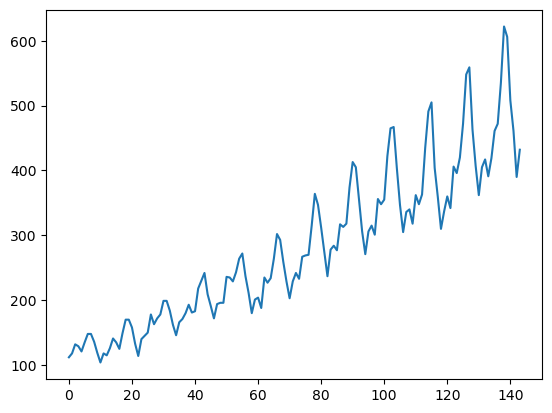

In [11]:
timeseries = df[['Passengers']].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [13]:
train_size = int(len(timeseries) * 0.7)
train, test = timeseries[:train_size], timeseries[train_size:]
print(len(train), len(test), len(train) + len(test))

100 44 144


In [21]:
lookback = 1

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99, 1, 1]) torch.Size([99, 1, 1])
torch.Size([43, 1, 1]) torch.Size([43, 1, 1])


In [25]:
#create model

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 

In [26]:
#train model
n_epochs = 2000

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 

Epoch 0: train RMSE 231.0614, test RMSE 429.1485
Epoch 100: train RMSE 188.7346, test RMSE 384.7433
Epoch 200: train RMSE 155.2466, test RMSE 348.4835
Epoch 300: train RMSE 126.1981, test RMSE 315.2605
Epoch 400: train RMSE 102.3633, test RMSE 284.9833
Epoch 500: train RMSE 83.0814, test RMSE 257.5589
Epoch 600: train RMSE 66.2972, test RMSE 231.2318
Epoch 700: train RMSE 53.1869, test RMSE 207.2393
Epoch 800: train RMSE 43.3605, test RMSE 185.8565
Epoch 900: train RMSE 35.8362, test RMSE 166.9790
Epoch 1000: train RMSE 31.1217, test RMSE 151.0683
Epoch 1100: train RMSE 28.7371, test RMSE 138.1823
Epoch 1200: train RMSE 27.5875, test RMSE 129.1619
Epoch 1300: train RMSE 25.2548, test RMSE 121.0718
Epoch 1400: train RMSE 26.0528, test RMSE 116.1812
Epoch 1500: train RMSE 24.4226, test RMSE 110.8837
Epoch 1600: train RMSE 23.8598, test RMSE 108.2561
Epoch 1700: train RMSE 23.7300, test RMSE 105.8502
Epoch 1800: train RMSE 24.8401, test RMSE 102.8724
Epoch 1900: train RMSE 25.8637, test R

In [27]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

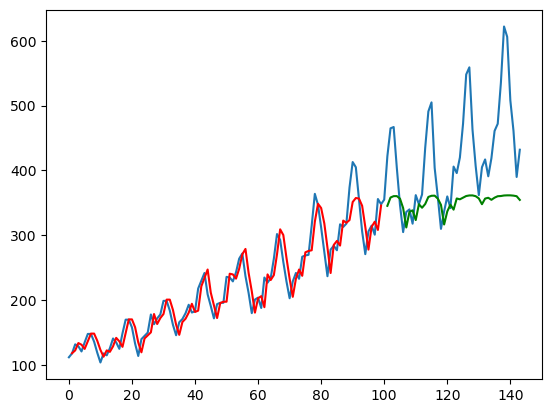

In [28]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()